# Recreation of accepted solution from Challenge

In [1]:
import torch
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

import numpy as np

import magnav

# 0 - Load Solution Dataset

In [2]:
# Create a widget to select the flight to load

w_flight = widgets.ToggleButtons(
    options=[('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5)],
    value=3,
    description='Load flight')
display(w_flight)

ToggleButtons(description='Load flight', index=1, options=(('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5))…

In [3]:
df = pd.read_hdf('../data/interim/Sol_dataset.h5', key=f'Flt100{w_flight.value}')

In [4]:
df.head()

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,LINE,IGRFMAG1
Time [s],,,,,,,,,,,,,
49820.0,52836.179,40991.107,56629.409,-24121.629,-22136.973,10486.244,-770.948052,53000.806,-1837.427211,-132.727664,26.210,1003.01,-183.066
49820.1,52834.254,40995.387,56629.059,-24107.552,-22123.009,10491.522,-761.257336,53011.817,-1837.994231,-131.784263,26.169,1003.01,-183.522
49820.2,52832.980,41000.448,56627.953,-24095.028,-22109.401,10497.816,-757.416996,53016.958,-1838.356508,-129.755380,26.022,1003.01,-183.957
49820.3,52832.305,41006.539,56626.660,-24084.577,-22097.326,10505.743,-759.437211,53016.190,-1838.998602,-127.464817,25.839,1003.01,-184.368
49820.4,52832.223,41013.213,56625.663,-24076.470,-22088.167,10515.313,-765.931913,53010.724,-1839.819941,-125.954372,25.731,1003.01,-184.759


In [5]:
df_filt = df[['TL_comp_mag3_sq','TL_comp_mag4_sq','TL_comp_mag5_sq']].loc[df.LINE==1003.02].copy()

# 1 - Preprocessing

## 1.1 - Low pass filter

This filter comes from Matlab lowpass filter (This are the coefficients extracted from Matlab)

In [6]:
num = [0.00013485,0.00014468,7.8213e-05,-0.00010382,-0.00043744,-0.00094761,-0.0016395,-0.0024902,-0.0034418,-0.0043974,
        -0.005221,-0.0057423,-0.0057668,-0.0050899,-0.003516,-0.00087932,0.0029351,0.007972,0.014191,0.021457,0.029541,0.03813,
        0.046838,0.055236,0.062881,0.069347,0.074263,0.077335,0.078381,0.077335,0.074263,0.069347,0.062881,0.055236,0.046838,
        0.03813,0.029541,0.021457,0.014191,0.007972,0.0029351,-0.00087932,-0.003516,-0.0050899,-0.0057668,-0.0057423,-0.005221,
        -0.0043974,-0.0034418,-0.0024902,-0.0016395,-0.00094761,-0.00043744,-0.00010382,7.8213e-05,0.00014468,0.00013485]
den = 1

sos = signal.tf2sos(num,den)

In [7]:
df_filt['FLUXB_TOT']  = signal.sosfiltfilt(sos,df['FLUXB_TOT'].loc[df.LINE==1003.02])
df_filt['FLUXB_X']    = signal.sosfiltfilt(sos,df['FLUXB_X'].loc[df.LINE==1003.02])
df_filt['FLUXC_TOT']  = signal.sosfiltfilt(sos,df['FLUXC_TOT'].loc[df.LINE==1003.02])
df_filt['FLUXC_Y']    = signal.sosfiltfilt(sos,df['FLUXC_Y'].loc[df.LINE==1003.02])
df_filt['FLUXD_Y']    = signal.sosfiltfilt(sos,df['FLUXD_Y'].loc[df.LINE==1003.02])
df_filt['FLUXD_Z']    = signal.sosfiltfilt(sos,df['FLUXD_Z'].loc[df.LINE==1003.02])
df_filt['UNCOMPMAG3'] = signal.sosfiltfilt(sos,df['UNCOMPMAG3'].loc[df.LINE==1003.02])
df_filt['V_CABT']     = signal.sosfiltfilt(sos,df['V_CABT'].loc[df.LINE==1003.02])

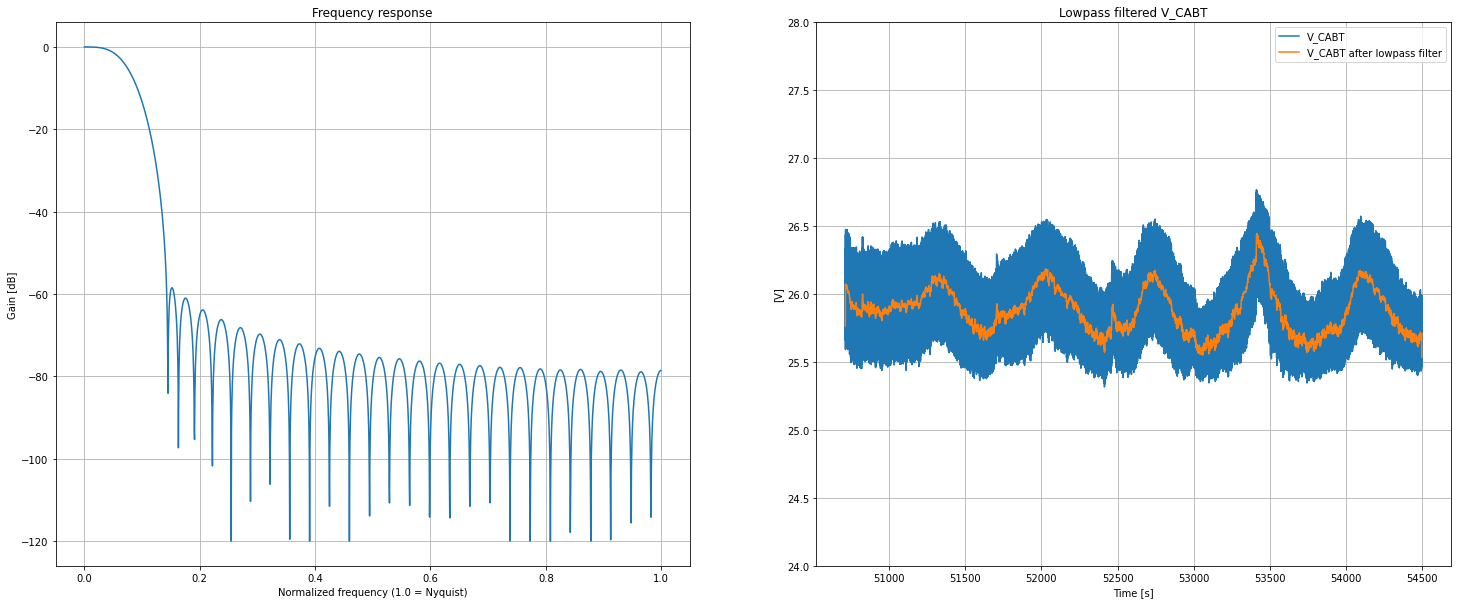

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[25,10])

w, h = signal.sosfreqz(sos, worN=2000)
db = 20*np.log10(np.maximum(np.abs(h),1e-6))

ax1.plot(w/np.pi,db)

ax1.grid()
ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)')
ax1.set_ylabel('Gain [dB]')
ax1.set_title('Frequency response')


window = 5000 # Number of seconds to plot 
ax2.plot(df['V_CABT'].loc[df.LINE==1003.02],label='V_CABT')
ax2.plot(df_filt['V_CABT'],label='V_CABT after lowpass filter')

ax2.grid()
ax2.legend()
ax2.set_ylim([24,28])
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[V]')
ax2.set_title('Lowpass filtered V_CABT')
plt.show()

## 1.2 - Standardization

<font size="5">
$z = \frac{x-\mu}{\sigma}$
</font>

Transformation to a standard normal distribution

In [9]:
df_filt.head()

,TL_comp_mag3_sq,TL_comp_mag4_sq,TL_comp_mag5_sq,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,UNCOMPMAG3,V_CABT
Time [s],,,,,,,,,,,
50713.0,-950.772376,-2071.372550,-61.063570,52809.995683,45836.756733,57309.609235,-20373.111110,-17985.300142,16380.959101,53524.214262,25.764129
50713.1,-948.311424,-2070.150151,-61.193859,52810.549017,45821.237035,57309.093511,-20398.057302,-18011.092309,16355.481028,53522.168433,25.799961
50713.2,-945.399256,-2068.744456,-60.430321,52811.056880,45805.304785,57308.501120,-20422.486899,-18036.394727,16329.119145,53520.056058,25.835170
50713.3,-942.605337,-2067.344488,-59.631363,52811.476194,45788.571859,57307.759115,-20445.895748,-18060.728540,16301.037242,53517.815189,25.869157
50713.4,-940.197260,-2066.215693,-58.782155,52811.768560,45770.697930,57306.801853,-20467.803994,-18083.636157,16270.492298,53515.392854,25.901375


In [10]:
df_filt = (df_filt-np.mean(df.drop(columns=['IGRFMAG1','LINE'])))/np.std(df.drop(columns=['IGRFMAG1','LINE']))

In [11]:
df_filt.describe()

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,TL_comp_mag4_sq,TL_comp_mag5_sq,UNCOMPMAG3,V_CABT
count,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000,37841.000000
mean,-0.326072,-0.014777,-0.124348,-0.079694,-0.080324,-0.021916,-0.385932,-0.322104,-0.140544,-0.243573,-0.066499
std,0.966609,0.934464,0.922059,1.075582,1.074260,0.930069,1.035647,1.042726,1.294923,0.887257,0.559713
min,-2.196359,-2.670359,-2.517563,-1.561719,-1.615520,-2.221383,-2.486033,-2.477008,-2.833500,-1.770043,-1.219491
25%,-1.241104,-0.996551,-0.993096,-1.319697,-1.321892,-0.940816,-1.164944,-1.032385,-0.877179,-0.918859,-0.543345
50%,-0.332689,0.319816,-0.070072,0.576684,0.570444,0.142077,-0.466291,-0.383404,-0.328125,-0.412232,-0.083926
75%,0.384357,0.663789,0.540696,0.840441,0.826692,0.546820,0.180055,0.125876,0.435046,0.095818,0.332474
max,3.303759,1.890095,2.439529,1.440007,1.468785,2.836014,4.953660,4.736453,5.673447,3.041470,1.832361


In [12]:
df_test = pd.concat([df_filt.transpose(),df_filt.transpose(),df_filt.transpose(),df_filt.transpose(),df_filt.transpose()])
df_test

Time [s],50713.0,50713.1,50713.2,50713.3,50713.4,50713.5,50713.6,50713.7,50713.8,50713.9,...,54496.1,54496.2,54496.3,54496.4,54496.5,54496.6,54496.7,54496.8,54496.9,54497.0
FLUXB_TOT,0.762744,0.763540,0.764270,0.764873,0.765293,0.765486,0.765417,0.765068,0.764435,0.763532,...,-1.416677,-1.420001,-1.424215,-1.429265,-1.435075,-1.441550,-1.448579,-1.456035,-1.463783,-1.471679
FLUXB_X,1.088219,1.086688,1.085117,1.083466,1.081703,1.079800,1.077740,1.075515,1.073127,1.070591,...,-0.630119,-0.633563,-0.638236,-0.644057,-0.650915,-0.658676,-0.667185,-0.676272,-0.685750,-0.695427
FLUXC_TOT,0.907482,0.907104,0.906670,0.906126,0.905424,0.904524,0.903396,0.902020,0.900391,0.898518,...,-0.773848,-0.777816,-0.783042,-0.789446,-0.796919,-0.805327,-0.814511,-0.824295,-0.834487,-0.844886
FLUXC_Y,-1.210690,-1.212435,-1.214144,-1.215782,-1.217315,-1.218711,-1.219944,-1.220988,-1.221822,-1.222431,...,1.079098,1.078162,1.076987,1.075584,1.073972,1.072177,1.070228,1.068160,1.066011,1.063821
FLUXD_Y,-1.190870,-1.192686,-1.194468,-1.196181,-1.197794,-1.199276,-1.200601,-1.201744,-1.202683,-1.203403,...,1.074821,1.073761,1.072424,1.070824,1.068985,1.066934,1.064707,1.062343,1.059886,1.057382
FLUXD_Z,0.989959,0.988059,0.986092,0.983998,0.981720,0.979213,0.976444,0.973396,0.970066,0.966471,...,-0.519758,-0.523229,-0.527987,-0.533948,-0.541000,-0.549007,-0.557806,-0.567216,-0.577043,-0.587080
TL_comp_mag3_sq,-0.095105,-0.088849,-0.081446,-0.074343,-0.068221,-0.064057,-0.061812,-0.060694,-0.060179,-0.059141,...,-1.644933,-1.645595,-1.645168,-1.644186,-1.643514,-1.644056,-1.646028,-1.649337,-1.653657,-1.661949
TL_comp_mag4_sq,-0.446876,-0.442469,-0.437402,-0.432355,-0.428286,-0.426505,-0.425997,-0.425502,-0.424980,-0.422945,...,-1.368628,-1.365055,-1.359832,-1.353476,-1.347627,-1.343643,-1.342057,-1.343720,-1.348102,-1.355482
TL_comp_mag5_sq,-0.873830,-0.874500,-0.870578,-0.866474,-0.862112,-0.857405,-0.852254,-0.846490,-0.839939,-0.832673,...,-0.992012,-0.992036,-0.991453,-0.990355,-0.988797,-0.986869,-0.984861,-0.983227,-0.982147,-0.982037
UNCOMPMAG3,0.584426,0.582710,0.580938,0.579058,0.577026,0.574808,0.572384,0.569750,0.566919,0.563922,...,-0.910957,-0.914694,-0.919379,-0.924944,-0.931299,-0.938339,-0.945943,-0.953982,-0.962316,-0.970797


## 1.3 - Train, Test and Validation set

In [13]:
y_true = df[['IGRFMAG1']].loc[df.LINE==1003.02].copy()
print(y_true)

          IGRFMAG1
Time [s]          
50713.0    -87.226
50713.1    -86.141
50713.2    -85.007
50713.3    -83.824
50713.4    -82.591
...            ...
54496.6   -438.465
54496.7   -439.180
54496.8   -439.882
54496.9   -440.569
54497.0   -441.242

[37841 rows x 1 columns]


# 2 - MLP

GPU Check

In [14]:
magnav.check_GPU()

GPU in use : NVIDIA GeForce GTX 1660 Ti
